In [1]:
from proj_utils import *
import os, struct
import numpy as np
import cv2

In [2]:
import cv2
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import SGD
import numpy as np
from IPython.display import SVG
from keras.applications.inception_v3 import InceptionV3
from keras.utils.vis_utils import model_to_dot

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
path = os.path.join(os.path.curdir, 'data')
x_train, y_train = load_NMNIST('training', digits=[0,1,2], path=path)
x_test, y_test = load_NMNIST('testing', digits=[0,1,2], path=path)

In [4]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

def aug_img(img):
    img = np.reshape(img, (len(img), 28*28*1))
    img = min_max_scaler.fit_transform(img)
    img = np.reshape(img, (len(img), 28,28, 1))
    img = np.repeat(img, 3, 3)
    img = resize_data(img)
    return img

In [5]:
x_train = aug_img(x_train)
y_train = to_categorical(y_train)

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [6]:
inc_model = InceptionV3(weights='imagenet', include_top=False)

# get layers and add average pooling layer
x = inc_model.output
x = GlobalAveragePooling2D()(x)

# add fully-connected layer
#x = Dense(512, activation='relu')(x)
#x = Dense(256, activation='relu')(x)
#x = Dense(128, activation='relu')(x)
#x = Dense(64, activation='relu')(x)
#x = Dense(32, activation='relu')(x)
#x = Dense(16, activation='relu')(x)

# add output layer
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=inc_model.input, outputs=predictions)

# freeze pre-trained model area's layer
for layer in inc_model.layers:
    layer.trainable = False

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [7]:
# update the weight that are added
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
#history = model.fit(x_train, y_train)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [8]:
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
checkpoint_filename = 'InceptionV3.best_weights.hdf5'
callback_list = [TensorBoard(log_dir='/tmp/InceptionV3'),
                 ModelCheckpoint(checkpoint_filename, monitor='loss', verbose=1, save_best_only=True),
                 ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=2, factor=0.5)]

In [9]:
# choose the layers which are updated by training
layer_num = len(model.layers)
for layer in model.layers[:279]:
    layer.trainable = False

for layer in model.layers[279:]:
    layer.trainable = True

# training
model.compile(optimizer=SGD(lr=0.001, momentum=0.5), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train,
                    y_train,
                    batch_size=128,
                    epochs=5, shuffle=True,
                    validation_split=0.05,
                    callbacks=callback_list)

Train on 57000 samples, validate on 3000 samples
Epoch 1/5
57000/57000 [==============================] - 91s 2ms/step - loss: 0.2084 - acc: 0.9612 - val_loss: 0.0697 - val_acc: 0.9920
Epoch 2/5
57000/57000 [==============================] - 82s 1ms/step - loss: 0.0462 - acc: 0.9965 - val_loss: 0.0224 - val_acc: 0.9993
Epoch 3/5
57000/57000 [==============================] - 83s 1ms/step - loss: 0.0262 - acc: 0.9984 - val_loss: 0.0144 - val_acc: 0.9993
Epoch 4/5
57000/57000 [==============================] - 83s 1ms/step - loss: 0.0182 - acc: 0.9987 - val_loss: 0.0098 - val_acc: 0.9993
Epoch 5/5
57000/57000 [==============================] - 84s 1ms/step - loss: 0.0140 - acc: 0.9989 - val_loss: 0.0073 - val_acc: 0.9997


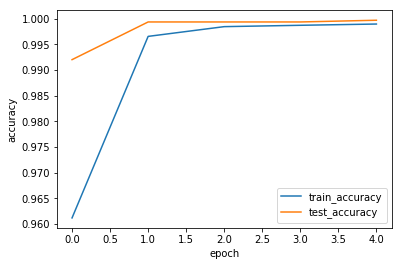

In [10]:
import matplotlib.pyplot as plt
def show_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'test_accuracy'], loc='best')
    plt.show()

show_history(history)

In [11]:
x_test = aug_img(x_test)
y_test = to_categorical(y_test)

In [12]:
model.load_weights(checkpoint_filename)
iv3_test_scores = model.evaluate(x_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (iv3_test_scores[1]*100))

10000/10000 [==============================] - 18s 2ms/step
Accuracy: 90.03%


In [14]:
from IPython.display import SVG
from keras.applications.inception_v3 import InceptionV3
from keras.utils.vis_utils import model_to_dot

In [ ]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
from IPython.display import SVG
from keras.applications.inception_v3 import InceptionV3
from keras.utils.vis_utils import model_to_dot
inception_model = InceptionV3(weights='imagenet', include_top=False)
SVG(model_to_dot(inception_model).create(prog='dot', format='svg'))

In [17]:
# check the layers by name
for i,layer in enumerate(model.layers):
    print(i,layer.name)

(0, 'input_1')
(1, 'conv2d_1')
(2, 'batch_normalization_1')
(3, 'activation_1')
(4, 'conv2d_2')
(5, 'batch_normalization_2')
(6, 'activation_2')
(7, 'conv2d_3')
(8, 'batch_normalization_3')
(9, 'activation_3')
(10, 'max_pooling2d_1')
(11, 'conv2d_4')
(12, 'batch_normalization_4')
(13, 'activation_4')
(14, 'conv2d_5')
(15, 'batch_normalization_5')
(16, 'activation_5')
(17, 'max_pooling2d_2')
(18, 'conv2d_9')
(19, 'batch_normalization_9')
(20, 'activation_9')
(21, 'conv2d_7')
(22, 'conv2d_10')
(23, 'batch_normalization_7')
(24, 'batch_normalization_10')
(25, 'activation_7')
(26, 'activation_10')
(27, 'average_pooling2d_1')
(28, 'conv2d_6')
(29, 'conv2d_8')
(30, 'conv2d_11')
(31, 'conv2d_12')
(32, 'batch_normalization_6')
(33, 'batch_normalization_8')
(34, 'batch_normalization_11')
(35, 'batch_normalization_12')
(36, 'activation_6')
(37, 'activation_8')
(38, 'activation_11')
(39, 'activation_12')
(40, 'mixed0')
(41, 'conv2d_16')
(42, 'batch_normalization_16')
(43, 'activation_16')
(44, 'c

In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (